# Full-batch FashionMNIST
We shall train a tiny (under 10k params) FashionMNIST convolutional neural network using full-batch training.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchzero as tz
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import random
from torchvision.datasets import FashionMNIST

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

train = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=True, download=True)
test = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=False, download=True)

In [2]:
def to_tensors(ds):
    inputs = []
    targets = []
    for input, target in ds:
        inputs.append(torch.tensor(np.array(input), dtype=torch.float32))
        targets.append(torch.tensor(np.array(target), dtype=torch.long))

    # znormalize
    inputs = torch.stack(inputs)
    inputs = (inputs - inputs.mean() / inputs.std())

    return inputs.cuda(), torch.stack(targets).cuda()

train_X, train_y = to_tensors(train)
test_X, test_y = to_tensors(test)

train_X.unsqueeze_(1)
test_X.unsqueeze_(1)
train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

In [3]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TinyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 3, 2)
        self.c2 = nn.Conv2d(16, 24, 3, 2)
        self.c3 = nn.Conv2d(24, 32, 2)
        self.head = nn.Conv2d(32, 10, 1)

    def forward(self, x):
        x = F.elu(self.c1(x))
        x = F.elu(self.c2(x))
        x = F.elu(self.c3(x))
        return self.head(x).sum((2,3))

print(TinyConvNet()(torch.randn(1,1,28,28)).shape)
count_params(TinyConvNet())

torch.Size([1, 10])


7074

In [ ]:
model = TinyConvNet().cuda()

opt = tz.Modular(
    model.parameters(),
    tz.m.LBFGS(100),
    tz.m.Backtracking(),
    tz.m.RelativeWeightDecay(0.1),
)

train_losses = []
test_losses = []
test_acc = []

def closure(backward=True):
    y_hat = model(train_X)
    loss = F.cross_entropy(y_hat, train_y)
    if backward:
        opt.zero_grad()
        loss.backward()

    # test loss
    with torch.no_grad():
        y_hat_test = model(test_X)
        test_loss = F.cross_entropy(y_hat_test, test_y)
        test_accuracy = (y_hat_test.argmax(-1) == test_y).float().mean()

    # log
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    test_acc.append(test_accuracy.item())

    return loss

pbar = tqdm.trange(1000)
for step in pbar:
    loss = opt.step(closure)
    pbar.set_description(str(loss))

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(0.2217, device='cuda:0', grad_fn=<NllLossBackward0>): 100%|██████████| 1000/1000 [06:47<00:00,  2.45it/s]


max(test_acc) = 0.8877999782562256


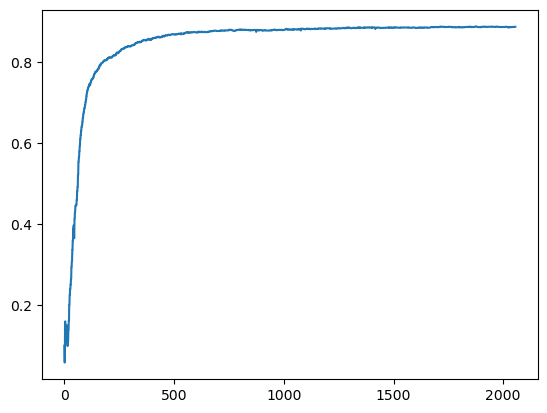

In [5]:
print(f"{max(test_acc) = }")
plt.plot(test_acc)